# Load Qick

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json
from datetime import datetime
import os
from qick_workspace.tools import system_cfg
from qick_workspace.tools.system_tool import select_config_idx, auto_unit
from qick import *
from qick.pyro import make_proxy
from qick import QickConfig
from qick.asm_v2 import QickSpan, QickSweep1D
import Pyro4

Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION = 4

ns_host = "192.168.10.63"
ns_port = 8888
proxy_name = "myqick"

soc, soccfg = make_proxy(ns_host=ns_host, ns_port=ns_port, proxy_name=proxy_name)
print(soccfg)

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_100127414b1446cf94bc54217e2af34c@192.168.10.63:43131
QICK running on ZCU216, software version 0.2.371

Firmware configuration (built Tue Sep 10 16:13:40 2024):

	Global clocks (MHz): tProc dispatcher timing 430.080, RF reference 245.760
	Groups of related clocks: [tProc timing clock, DAC tile 0, DAC tile 1, DAC tile 3], [DAC tile 2], [ADC tile 2]

	16 signal generator channels:
	0:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 16384 complex samples (1.709 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 0 is 0_230 on JHC3, or QICK box DAC port 8
	1:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 4096 complex samples (0.427 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 1 is 1_230 on JHC4, or QICK box DAC port 9
	2:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 8192 complex samples (0.855 us)
		32-bit DDS, range=9584.

In [2]:
from qick_workspace.tools.YOKOGS200 import YOKOGS200
import pyvisa

rm = pyvisa.ResourceManager()
yoko_connect = "USB0::0x0B21::0x0039::91WB18859::INSTR"
yoko = YOKOGS200(yoko_connect, rm)

yoko.OutputOn()

In [3]:
yoko_value = yoko.GetValue()
yoko_value

{'unit': 'A', 'value': -0.0023}

# Load system configuration

In [4]:
qubit_idx = 0

config = {
    **system_cfg.hw_cfg,
    **system_cfg.readout_cfg,
    **system_cfg.qubit_cfg,
    **system_cfg.expt_cfg,
    **system_cfg.cool_cfg,
}

In [5]:
from qick_workspace.scrip.s002_res_spec_ge import Resonator_onetone
from qick_workspace.scrip.s003_qubit_spec_ge import Qubit_Twotone
from qick_workspace.scrip.s005_power_rabi_ge import Amp_Rabi
from qick_workspace.scrip.s006_Ramsey_ge import Ramsey
from qick_workspace.scrip.s007_SpinEcho_ge import SpinEcho
from qick_workspace.scrip.s008_T1_ge import T1

# Test experiment config setting

In [6]:
config["nqz_qubit"] = 2
config["res_gain_ge"][qubit_idx] = 0.2
config["qubit_ch"] = 5
# Resonator One-tone Configuration
START_FREQ = config["res_freq_ge"][qubit_idx] - 10  # [MHz]
STOP_FREQ = config["res_freq_ge"][qubit_idx] + 10  # [MHz]
STEPS = 101

onetone_cfg = select_config_idx(config, qubit_idx)
onetone_cfg.update(
    [
        ("steps", STEPS),
        ("res_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("relax_delay", 1),
        ("cooling", False),
    ]
)

# Qubit Two-tone Configuration
center = 4600
SPAN = 100
START_FREQ = center - SPAN  # [MHz]
STOP_FREQ = center + SPAN  # [MHz]
STEPS = 201
run_cfg = select_config_idx(config, qubit_idx)
run_cfg.update(
    [
        ("steps", STEPS),
        ("qubit_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("qmixer_freq", center),
        ("qubit_gain_ge", 0.2),
        ("qubit_length_ge", 5),
        ("relax_delay", 1),
    ]
)

# Amp Rabi Configuration
START_GAIN = 0.0  # [DAC units]
STOP_GAIN = 1  # [DAC units]
STEPS = 100
config["sigma"][qubit_idx] = 0.05
config["relax_delay"] = 50  # [us]
run_cfg = select_config_idx(config, qubit_idx)
run_cfg.update(
    [
        ("steps", STEPS),
        ("qubit_gain_ge", QickSweep1D("gainloop", START_GAIN, STOP_GAIN)),
    ]
)

# Ramsey Configuration
START_TIME = 0.0  # [us]
STOP_TIME = 5  # [us]
STEPS = 100
run_cfg = select_config_idx(config, qubit_idx)
run_cfg.update(
    [
        ("steps", STEPS),
        ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
        ("ramsey_freq", 2),
    ]
)
# Spin Echo Configuration
START_TIME = 0.0  # [us]
STOP_TIME = 10  # [us]
STEPS = 100
run_cfg.update(
    [
        ("steps", STEPS),
        ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
        ("ramsey_freq", 1),
    ]
)

# T1 Configuration
run_cfg = select_config_idx(config, qubit_idx)

START_TIME = 0.0  # [us]
STOP_TIME = 100  # [us]
STEPS = 100
run_cfg.update(
    [
        ("steps", STEPS),
        ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
        ("relax_delay", 50),
        ("cooling", False),
        ("qubit_ch", 7),
    ]
)

# Auto Experiment

In [20]:
qubit_idx = 0
pyavg = 1

from qick_workspace.tools import fitting as fitter


def process_fitting(xpts, data, fitfunc):
    data = {
        "xpts": xpts,
        "amps": np.abs(data),
        "phase": np.unwrap(np.angle(data)),
        "avgi": data.real,
        "avgq": data.imag,
    }

    for measure in ("amps", "phase", "avgi", "avgq"):
        popt, pcov, f = fitfunc(data["xpts"], data[measure])
        data[f"fit_{measure}"] = popt
        data[f"fit_err_{measure}"] = pcov

    fit_params, fit_err, best_measure = fitter.get_best_fit(data, fitfunc=None)

    return fit_params, fit_err, best_measure


def fix_phase(p) -> float:
    """
    Normalize phase and calculate pi gain.

    Args:
        p: Parameters list containing phase information

    Returns:
        Pi gain value
    """
    if p[2] > 180:
        p[2] = p[2] - 360
    elif p[2] < -180:
        p[2] = p[2] + 360

    if p[2] < 0:
        pi_gain = (1 / 2 - p[2] / 180) / 2 / p[1]
        pi2_gain = (0 - p[2] / 180) / 2 / p[1]
    else:
        pi_gain = (3 / 2 - p[2] / 180) / 2 / p[1]
        pi2_gain = (1 - p[2] / 180) / 2 / p[1]
    return pi_gain, pi2_gain


class auto:
    def __init__(self, cfg) -> None:
        self.cfg = cfg
        self.cfg["nqz_qubit"] = 2
        self.cfg["res_gain_ge"][qubit_idx] = 0.2
        self.cfg["qubit_ch"] = 5
        self.cfg["sigma"][qubit_idx] = 0.005
        self.report = {}

    def auto_onetone(self):
        # Resonator One-tone Configuration
        START_FREQ = self.cfg["res_freq_ge"][qubit_idx] - 10  # [MHz]
        STOP_FREQ = self.cfg["res_freq_ge"][qubit_idx] + 10  # [MHz]
        STEPS = 101

        onetone_cfg = select_config_idx(self.cfg, qubit_idx)
        onetone_cfg.update(
            [
                ("steps", STEPS),
                ("res_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
                ("relax_delay", 1),
            ]
        )
        res_onetone = Resonator_onetone(soc, soccfg, onetone_cfg)
        res_onetone.auto(py_avg=pyavg)
        ## update value ##
        fres = res_onetone.plot_circle()
        self.cfg["res_freq_ge"][qubit_idx] = round(fres[0] / 1e6, 4)
        print(
            "Updated Resonator Frequency: ", self.cfg["res_freq_ge"][qubit_idx], " MHz"
        )
        self.report["resonator_frequency_MHz"] = self.cfg["res_freq_ge"][qubit_idx]

    def auto_freq(self, lookup_list):
        yoko.SetCurrent(lookup_list[0])
        print("Set Yoko Current to:", yoko.GetValue())
        self.f_ge_guess = lookup_list[1]

    def auto_twotone(self):
        # Qubit Two-tone Configuration
        center = self.f_ge_guess
        SPAN = 100
        START_FREQ = center - SPAN  # [MHz]
        STOP_FREQ = center + SPAN  # [MHz]
        STEPS = 201
        run_cfg = select_config_idx(self.cfg, qubit_idx)
        run_cfg.update(
            [
                ("steps", STEPS),
                ("qubit_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
                ("qmixer_freq", center),
                ("qubit_gain_ge", 0.2),
                ("qubit_length_ge", 5),
                ("relax_delay", 1),
            ]
        )
        spectrum_ge = Qubit_Twotone(soc, soccfg, run_cfg)
        spectrum_ge.auto(py_avg=pyavg)
        freq, iq = spectrum_ge.freqs, spectrum_ge.iqdata
        pOpt, pCov, fitparams = process_fitting(freq, iq, fitter.fitlor)
        self.cfg["qubit_freq_ge"][qubit_idx] = round(pOpt[2], 6)
        self.cfg["qmixer_freq"][qubit_idx] = round(pOpt[2], 6)
        print("Updated Qubit Frequency: ", self.cfg["qubit_freq_ge"][qubit_idx], " MHz")
        self.report["qubit_frequency_MHz"] = self.cfg["qubit_freq_ge"][qubit_idx]

    def auto_rabi(self):
        # Amp Rabi Configuration
        START_GAIN = 0.0  # [DAC units]
        STOP_GAIN = 1  # [DAC units]
        STEPS = 100
        self.cfg["relax_delay"] = 50  # [us]

        run_cfg = select_config_idx(self.cfg, qubit_idx)
        current_sigma = self.cfg["sigma"][qubit_idx]
        run_cfg.update(
            [
                ("steps", STEPS),
                ("sigma", current_sigma),
                ("qubit_gain_ge", QickSweep1D("gainloop", START_GAIN, STOP_GAIN)),
            ]
        )

        prabi = Amp_Rabi(soc, soccfg, run_cfg)
        prabi.auto(py_avg=pyavg)
        pOpt, pCov, fitparams = process_fitting(
            prabi.gains, prabi.iqdata, fitter.fitdecaysin
        )

        pi_gain, pi2_gain = fix_phase(pOpt)
        self.report["rabi_pi_gain"] = pi_gain
        self.report["rabi_pi2_gain"] = pi2_gain
        self.report["sigma"] = current_sigma
        return pi_gain, pi2_gain

    def auto_rabi_loop(self, max_iterations=5):
        pi_gain = 2.0
        iteration = 0

        while pi_gain > 0.9 and iteration < max_iterations:
            iteration += 1
            current_sigma = self.cfg["sigma"][qubit_idx]
            print(
                f"\n[{iteration}/{max_iterations}] Running Rabi. Current sigma: {current_sigma:.4f}"
            )

            pi_gain, pi2_gain = self.auto_rabi()

            if pi_gain > 0.9:
                old_sigma = self.cfg["sigma"][qubit_idx]
                new_sigma = old_sigma + 0.01

                self.cfg["sigma"][qubit_idx] = round(new_sigma, 4)

                print(
                    f"  ❌ Pi Gain ({pi_gain:.4f}) too high. Sigma -> {new_sigma:.4f}"
                )
            else:
                self.cfg["qubit_pi_gain_ge"][qubit_idx] = pi_gain
                self.cfg["qubit_pi2_gain_ge"][qubit_idx] = pi2_gain

                print(f"  ✅ Pi Gain ({pi_gain:.4f}) OK. Loop finished.")

        if pi_gain > 0.9 and iteration == max_iterations:
            print("\n⚠️ WARNING: Max iterations reached. Pi gain still > 0.9.")

    def auto_ramsey(self):
        START_TIME = 0.0  # [us]
        STOP_TIME = 8  # [us]
        STEPS = 100
        run_cfg = select_config_idx(self.cfg, qubit_idx)
        run_cfg.update(
            [
                ("steps", STEPS),
                ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
                ("ramsey_freq", 2),
            ]
        )
        ramsey = Ramsey(soc, soccfg, run_cfg)
        ramsey.auto(py_avg=pyavg)
        pOpt, pCov, fitparams = process_fitting(
            ramsey.delay_times, ramsey.iqdata, fitter.fitdecaysin
        )
        self.report["T2_ramsey_us"] = pOpt[3]
        return pOpt

    def auto_finetune_loop(self, max_iterations=3):
        DETUNE_THRESHOLD = 0.005
        iteration = 0
        current_detune = DETUNE_THRESHOLD + 1.0

        print("\n--- Starting Qubit Frequency Fine-Tuning Loop ---")

        while abs(current_detune) > DETUNE_THRESHOLD and iteration < max_iterations:
            iteration += 1
            print(f"[{iteration}/{max_iterations}] Running Ramsey to measure detune...")

            pOpt = self.auto_ramsey()
            current_detune = pOpt[1] - self.cfg["ramsey_freq"]

            if abs(current_detune) > DETUNE_THRESHOLD:
                adjustment = round(current_detune, 2)

                old_freq = self.cfg["qubit_freq_ge"][qubit_idx]
                new_freq = old_freq - adjustment

                self.cfg["qubit_freq_ge"][qubit_idx] = new_freq

                print(
                    f"Detune: {current_detune:.5f} MHz. Adjusting freq: {old_freq:.5f} MHz -> {new_freq:.5f} MHz"
                )
            else:
                print(
                    f"Detune: {current_detune:.5f} MHz (< {DETUNE_THRESHOLD} MHz). Loop finished."
                )
                break

        if abs(current_detune) > DETUNE_THRESHOLD and iteration == max_iterations:
            print(
                f"\nWARNING: Max iterations reached. Final detune is {current_detune:.5f} MHz."
            )

        return self.cfg["qubit_freq_ge"][qubit_idx]

    def auto_echo(self):
        START_TIME = 0.0  # [us]
        STOP_TIME = 8  # [us]
        STEPS = 100
        run_cfg = select_config_idx(self.cfg, qubit_idx)
        run_cfg.update(
            [
                ("steps", STEPS),
                ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
            ]
        )
        echo = SpinEcho(soc, soccfg, run_cfg)
        echo.auto(py_avg=pyavg)
        pOpt, pCov, fitparams = process_fitting(
            echo.delay_times, echo.iqdata, fitter.fitdecaysin
        )

        print("Updated Qubit T2 Echo: ", round(pOpt[3], 3), " us")
        self.report["T2_echo_us"] = pOpt[3]
        return pOpt

    def auto_t1(self):
        START_TIME = 0.0  # [us]
        STOP_TIME = 100  # [us]
        STEPS = 100
        run_cfg = select_config_idx(self.cfg, qubit_idx)
        run_cfg.update(
            [
                ("steps", STEPS),
                ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
            ]
        )

        t1_exp = T1(soc, soccfg, run_cfg)
        t1_exp.auto(py_avg=pyavg)
        pOpt, pCov, fitparams = process_fitting(
            t1_exp.delay_times, t1_exp.iqdata, fitter.fitexp
        )
        self.report["T1_us"] = pOpt[2]
        print("Updated Qubit T1: ", round(pOpt[2], 3), " us")

    def auto_report(self):
        print("Auto calibration report:")
        print(f"Resonator Frequency {self.report['resonator_frequency_MHz']:.3f} MHz")
        print(f"Qubit Frequency {self.report['qubit_frequency_MHz']:.3f} MHz")
        print(f"Rabi Pi Gain {self.report['rabi_pi_gain']:.3f}")
        print(f"Rabi Pi/2 Gain {self.report['rabi_pi2_gain']:.3f}")
        print(f"Sigma {self.report['sigma']:.3f} us")
        print(f"T2 Ramsey {self.report['T2_ramsey_us']:.3f} us")
        print(f"T2 Echo {self.report['T2_echo_us']:.3f} us")
        print(f"T1 {self.report['T1_us']:.3f} us")

    def dump_report_json(self, filename=None, yokovaue=None):
        if filename is None:
            filename = "auto_report.json"

        root_folder = datetime.now().strftime("%Y%m%d")

        value = yoko.GetValue()
        mode = value["unit"]

        unit_scaled = auto_unit(value["value"])["unit"]
        values_scaled = auto_unit(value["value"])["value"]

        final_report = {
            "timestamp": datetime.now().strftime("%Y-%m-%d-%H:%M:%S"),
            "instrument": {
                "yoko_mode": mode,
                "yoko_unit_scaled": f"{values_scaled:.2f} {unit_scaled}{mode}",
            },
            "calibration_results": self.report.copy(),
        }

        subfolder_name = os.path.splitext(filename)[0]

        if yokovaue is not None:
            filename_base = (
                f"{subfolder_name}_{values_scaled:.2f}_{unit_scaled}{mode}.json"
            )
        else:
            filename_base = filename

        nested_dir = os.path.join(root_folder, subfolder_name)

        if not os.path.exists(nested_dir):
            os.makedirs(nested_dir)

        full_filepath = os.path.join(nested_dir, filename_base)

        with open(full_filepath, "w") as f:
            json.dump(final_report, f, indent=4)

        print(f"Report saved to {full_filepath}")

In [18]:
import json
import os
from typing import List, Any


def read_qubit_current_sweep_simple(
    filename: str = "qubit_auto_test.json",
) -> List[List[float]]:
    if not os.path.exists(filename):
        print(f"Error: File not found at {filename}")
        return []

    try:
        with open(filename, "r") as f:
            data = json.load(f)

    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {filename}")
        return []

    freq_data = data.get("qubit_freq_vs_current", {})
    if not isinstance(freq_data, dict):
        print("Error: JSON structure 'qubit_freq_vs_current' is not a dictionary.")
        return []

    combined_data = []

    for current_key, freq_value in freq_data.items():
        processed_key = current_key.strip()
        current_A = None

        if processed_key.endswith(" A"):
            try:
                current_A = float(processed_key.replace(" A", ""))
            except ValueError:
                pass

        if current_A is not None and isinstance(freq_value, (int, float)):
            combined_data.append([current_A, freq_value])
        else:
            print(
                f"Warning: Skipping unparsable key/value pair: '{current_key}' -> {freq_value}"
            )

    print(f"Successfully loaded {len(combined_data)} data points from {filename}")

    return combined_data


lookup = read_qubit_current_sweep_simple("qubit_auto_test.json")


Successfully loaded 8 data points from qubit_auto_test.json


In [21]:
from time import time

start = time()
for lst in lookup:
    print("=== Starting auto calibration for lookup")
    print("Yoko Current set to:", lst[0], "A")
    print("Qubit Frequency guess:", lst[1], "MHz")

    cal = auto(config)
    cal.auto_freq(lookup_list=lst)
    cal.auto_onetone()
    cal.auto_twotone()
    cal.auto_rabi_loop(max_iterations=10)
    cal.auto_finetune_loop(max_iterations=10)
    cal.auto_rabi()
    cal.auto_echo()
    cal.auto_t1()
    cal.auto_report()
    cal.dump_report_json(filename="test.json", yokovaue=yoko.GetValue())
end = time()
print(f"\nTotal auto calibration time: {end - start:.2f} seconds")

=== Starting auto calibration for lookup
Yoko Current set to: -0.0028 A
Qubit Frequency guess: 4636.460321 MHz
Set Yoko Current to: {'unit': 'A', 'value': -0.0028}


  0%|          | 0/10100 [00:00<?, ?it/s]

{'Fres(GHz)': np.float64(5.3515),
 'Qi': 16523,
 'Ql': 939,
 'absQc': 996,
 'κ(MHz)': np.float64(5.7)}
Updated Resonator Frequency:  5351.511  MHz


  0%|          | 0/20100 [00:00<?, ?it/s]

Updated Qubit Frequency:  4637.208488  MHz

[1/10] Running Rabi. Current sigma: 0.0050


  0%|          | 0/10000 [00:00<?, ?it/s]

  ❌ Pi Gain (1.7584) too high. Sigma -> 0.0150

[2/10] Running Rabi. Current sigma: 0.0150


  0%|          | 0/10000 [00:00<?, ?it/s]

  ❌ Pi Gain (1.1921) too high. Sigma -> 0.0250

[3/10] Running Rabi. Current sigma: 0.0250


  0%|          | 0/10000 [00:00<?, ?it/s]

  ✅ Pi Gain (0.7581) OK. Loop finished.

--- Starting Qubit Frequency Fine-Tuning Loop ---
[1/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 0.04193 MHz. Adjusting freq: 4637.20849 MHz -> 4637.16849 MHz
[2/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 0.00066 MHz (< 0.005 MHz). Loop finished.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updated Qubit T2 Echo:  4.1  us


  0%|          | 0/10000 [00:00<?, ?it/s]

Updated Qubit T1:  7.295  us
Auto calibration report:
Resonator Frequency 5351.511 MHz
Qubit Frequency 4637.208 MHz
Rabi Pi Gain 0.763
Rabi Pi/2 Gain 0.408
Sigma 0.025 us
T2 Ramsey 5.080 us
T2 Echo 4.100 us
T1 7.295 us
Report saved to 20251113\test\test_-2.80_mA.json
=== Starting auto calibration for lookup
Yoko Current set to: -0.0025 A
Qubit Frequency guess: 4633.081206 MHz
Set Yoko Current to: {'unit': 'A', 'value': -0.0025}


  0%|          | 0/10100 [00:00<?, ?it/s]

{'Fres(GHz)': np.float64(5.3515),
 'Qi': 16862,
 'Ql': 919,
 'absQc': 971,
 'κ(MHz)': np.float64(5.83)}
Updated Resonator Frequency:  5351.5221  MHz


  0%|          | 0/20100 [00:00<?, ?it/s]

Updated Qubit Frequency:  4633.413179  MHz

[1/10] Running Rabi. Current sigma: 0.0050


  0%|          | 0/10000 [00:00<?, ?it/s]

  ❌ Pi Gain (2.1736) too high. Sigma -> 0.0150

[2/10] Running Rabi. Current sigma: 0.0150


  0%|          | 0/10000 [00:00<?, ?it/s]

  ❌ Pi Gain (1.7320) too high. Sigma -> 0.0250

[3/10] Running Rabi. Current sigma: 0.0250


  0%|          | 0/10000 [00:00<?, ?it/s]

  ✅ Pi Gain (0.7661) OK. Loop finished.

--- Starting Qubit Frequency Fine-Tuning Loop ---
[1/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 0.54548 MHz. Adjusting freq: 4633.41318 MHz -> 4632.86318 MHz
[2/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -0.00424 MHz (< 0.005 MHz). Loop finished.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updated Qubit T2 Echo:  6.621  us


  0%|          | 0/10000 [00:00<?, ?it/s]

Updated Qubit T1:  8.892  us
Auto calibration report:
Resonator Frequency 5351.522 MHz
Qubit Frequency 4633.413 MHz
Rabi Pi Gain 0.758
Rabi Pi/2 Gain 0.399
Sigma 0.025 us
T2 Ramsey 2.997 us
T2 Echo 6.621 us
T1 8.892 us
Report saved to 20251113\test\test_-2.50_mA.json
=== Starting auto calibration for lookup
Yoko Current set to: -0.0023 A
Qubit Frequency guess: 4625.6479 MHz
Set Yoko Current to: {'unit': 'A', 'value': -0.0023}


  0%|          | 0/10100 [00:00<?, ?it/s]

{'Fres(GHz)': np.float64(5.3514),
 'Qi': 1511,
 'Ql': -406,
 'absQc': -320,
 'κ(MHz)': np.float64(-13.19)}
Updated Resonator Frequency:  5351.4024  MHz


  0%|          | 0/20100 [00:00<?, ?it/s]

Updated Qubit Frequency:  4625.187947  MHz

[1/10] Running Rabi. Current sigma: 0.0050


  0%|          | 0/10000 [00:00<?, ?it/s]

  ✅ Pi Gain (0.1202) OK. Loop finished.

--- Starting Qubit Frequency Fine-Tuning Loop ---
[1/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 3.58223 MHz. Adjusting freq: 4625.18795 MHz -> 4621.60795 MHz
[2/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 3.55667 MHz. Adjusting freq: 4621.60795 MHz -> 4618.04795 MHz
[3/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -0.85818 MHz. Adjusting freq: 4618.04795 MHz -> 4618.90795 MHz
[4/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -1.65710 MHz. Adjusting freq: 4618.90795 MHz -> 4620.56795 MHz
[5/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -1.21113 MHz. Adjusting freq: 4620.56795 MHz -> 4621.77795 MHz
[6/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -1.50580 MHz. Adjusting freq: 4621.77795 MHz -> 4623.28795 MHz
[7/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -1.75007 MHz. Adjusting freq: 4623.28795 MHz -> 4625.03795 MHz
[8/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 0.93255 MHz. Adjusting freq: 4625.03795 MHz -> 4624.10795 MHz
[9/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 0.16748 MHz. Adjusting freq: 4624.10795 MHz -> 4623.93795 MHz
[10/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 0.18955 MHz. Adjusting freq: 4623.93795 MHz -> 4623.74795 MHz



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updated Qubit T2 Echo:  2.348  us


  0%|          | 0/10000 [00:00<?, ?it/s]

Updated Qubit T1:  -10.655  us
Auto calibration report:
Resonator Frequency 5351.402 MHz
Qubit Frequency 4625.188 MHz
Rabi Pi Gain 0.201
Rabi Pi/2 Gain 0.121
Sigma 0.005 us
T2 Ramsey 2.348 us
T2 Echo 2.348 us
T1 -10.655 us
Report saved to 20251113\test\test_-2.30_mA.json
=== Starting auto calibration for lookup
Yoko Current set to: -0.0021 A
Qubit Frequency guess: 4613.028754 MHz
Set Yoko Current to: {'unit': 'A', 'value': -0.0021}


  0%|          | 0/10100 [00:00<?, ?it/s]

{'Fres(GHz)': np.float64(5.3515),
 'Qi': 18260,
 'Ql': 963,
 'absQc': 1017,
 'κ(MHz)': np.float64(5.56)}
Updated Resonator Frequency:  5351.4527  MHz


  0%|          | 0/20100 [00:00<?, ?it/s]

Updated Qubit Frequency:  4613.078558  MHz

[1/10] Running Rabi. Current sigma: 0.0050


  0%|          | 0/10000 [00:00<?, ?it/s]

  ✅ Pi Gain (0.1108) OK. Loop finished.

--- Starting Qubit Frequency Fine-Tuning Loop ---
[1/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 2.04025 MHz. Adjusting freq: 4613.07856 MHz -> 4611.03856 MHz
[2/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -1.59934 MHz. Adjusting freq: 4611.03856 MHz -> 4612.63856 MHz
[3/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -1.81026 MHz. Adjusting freq: 4612.63856 MHz -> 4614.44856 MHz
[4/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -0.85106 MHz. Adjusting freq: 4614.44856 MHz -> 4615.29856 MHz
[5/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 3.32318 MHz. Adjusting freq: 4615.29856 MHz -> 4611.97856 MHz
[6/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 3.83949 MHz. Adjusting freq: 4611.97856 MHz -> 4608.13856 MHz
[7/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -1.56647 MHz. Adjusting freq: 4608.13856 MHz -> 4609.70856 MHz
[8/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -1.11806 MHz. Adjusting freq: 4609.70856 MHz -> 4610.82856 MHz
[9/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -0.84988 MHz. Adjusting freq: 4610.82856 MHz -> 4611.67856 MHz
[10/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 3.61988 MHz. Adjusting freq: 4611.67856 MHz -> 4608.05856 MHz



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updated Qubit T2 Echo:  2.348  us


  0%|          | 0/10000 [00:00<?, ?it/s]

Updated Qubit T1:  70.649  us
Auto calibration report:
Resonator Frequency 5351.453 MHz
Qubit Frequency 4613.079 MHz
Rabi Pi Gain 0.016
Rabi Pi/2 Gain 0.011
Sigma 0.005 us
T2 Ramsey 2.348 us
T2 Echo 2.348 us
T1 70.649 us
Report saved to 20251113\test\test_-2.10_mA.json
=== Starting auto calibration for lookup
Yoko Current set to: -0.0019 A
Qubit Frequency guess: 4595.701407 MHz
Set Yoko Current to: {'unit': 'A', 'value': -0.0019}


  0%|          | 0/10100 [00:00<?, ?it/s]

{'Fres(GHz)': np.float64(5.3514),
 'Qi': 20118,
 'Ql': 939,
 'absQc': 985,
 'κ(MHz)': np.float64(5.7)}
Updated Resonator Frequency:  5351.4363  MHz


  0%|          | 0/20100 [00:00<?, ?it/s]

Updated Qubit Frequency:  4597.180746  MHz

[1/10] Running Rabi. Current sigma: 0.0050


  0%|          | 0/10000 [00:00<?, ?it/s]

  ✅ Pi Gain (0.4178) OK. Loop finished.

--- Starting Qubit Frequency Fine-Tuning Loop ---
[1/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 1.14168 MHz. Adjusting freq: 4597.18075 MHz -> 4596.04075 MHz
[2/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 3.79369 MHz. Adjusting freq: 4596.04075 MHz -> 4592.25075 MHz
[3/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 0.05100 MHz. Adjusting freq: 4592.25075 MHz -> 4592.20075 MHz
[4/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 2.11763 MHz. Adjusting freq: 4592.20075 MHz -> 4590.08075 MHz
[5/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 3.40503 MHz. Adjusting freq: 4590.08075 MHz -> 4586.67075 MHz
[6/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 1.64028 MHz. Adjusting freq: 4586.67075 MHz -> 4585.03075 MHz
[7/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 0.13928 MHz. Adjusting freq: 4585.03075 MHz -> 4584.89075 MHz
[8/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 0.14159 MHz. Adjusting freq: 4584.89075 MHz -> 4584.75075 MHz
[9/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 1.10537 MHz. Adjusting freq: 4584.75075 MHz -> 4583.64075 MHz
[10/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -0.44199 MHz. Adjusting freq: 4583.64075 MHz -> 4584.08075 MHz



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updated Qubit T2 Echo:  2.348  us


  0%|          | 0/10000 [00:00<?, ?it/s]

Updated Qubit T1:  38.194  us
Auto calibration report:
Resonator Frequency 5351.436 MHz
Qubit Frequency 4597.181 MHz
Rabi Pi Gain 1.945
Rabi Pi/2 Gain 1.168
Sigma 0.005 us
T2 Ramsey 2.348 us
T2 Echo 2.348 us
T1 38.194 us
Report saved to 20251113\test\test_-1.90_mA.json
=== Starting auto calibration for lookup
Yoko Current set to: -0.0017 A
Qubit Frequency guess: 4573.402983 MHz
Set Yoko Current to: {'unit': 'A', 'value': -0.0017}


  0%|          | 0/10100 [00:00<?, ?it/s]

{'Fres(GHz)': np.float64(5.3512),
 'Qi': 1571,
 'Ql': -405,
 'absQc': -322,
 'κ(MHz)': np.float64(-13.23)}
Updated Resonator Frequency:  5351.1884  MHz


  0%|          | 0/20100 [00:00<?, ?it/s]

Updated Qubit Frequency:  4574.156403  MHz

[1/10] Running Rabi. Current sigma: 0.0050


  0%|          | 0/10000 [00:00<?, ?it/s]

  ✅ Pi Gain (0.0165) OK. Loop finished.

--- Starting Qubit Frequency Fine-Tuning Loop ---
[1/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 3.65778 MHz. Adjusting freq: 4574.15640 MHz -> 4570.49640 MHz
[2/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -1.81528 MHz. Adjusting freq: 4570.49640 MHz -> 4572.31640 MHz
[3/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -1.42921 MHz. Adjusting freq: 4572.31640 MHz -> 4573.74640 MHz
[4/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -0.91082 MHz. Adjusting freq: 4573.74640 MHz -> 4574.65640 MHz
[5/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 2.28902 MHz. Adjusting freq: 4574.65640 MHz -> 4572.36640 MHz
[6/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 2.88207 MHz. Adjusting freq: 4572.36640 MHz -> 4569.48640 MHz
[7/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -1.00477 MHz. Adjusting freq: 4569.48640 MHz -> 4570.48640 MHz
[8/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 3.79147 MHz. Adjusting freq: 4570.48640 MHz -> 4566.69640 MHz
[9/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -1.30347 MHz. Adjusting freq: 4566.69640 MHz -> 4567.99640 MHz
[10/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 2.87841 MHz. Adjusting freq: 4567.99640 MHz -> 4565.11640 MHz



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updated Qubit T2 Echo:  2.348  us


  0%|          | 0/10000 [00:00<?, ?it/s]

Updated Qubit T1:  4.86  us
Auto calibration report:
Resonator Frequency 5351.188 MHz
Qubit Frequency 4574.156 MHz
Rabi Pi Gain 0.039
Rabi Pi/2 Gain 0.004
Sigma 0.005 us
T2 Ramsey 2.348 us
T2 Echo 2.348 us
T1 4.860 us
Report saved to 20251113\test\test_-1.70_mA.json
=== Starting auto calibration for lookup
Yoko Current set to: -0.0015 A
Qubit Frequency guess: 4545.70999 MHz
Set Yoko Current to: {'unit': 'A', 'value': -0.0015}


  0%|          | 0/10100 [00:00<?, ?it/s]

{'Fres(GHz)': np.float64(5.3511),
 'Qi': 1532,
 'Ql': -409,
 'absQc': -323,
 'κ(MHz)': np.float64(-13.09)}
Updated Resonator Frequency:  5351.0693  MHz


  0%|          | 0/20100 [00:00<?, ?it/s]

Updated Qubit Frequency:  4545.691142  MHz

[1/10] Running Rabi. Current sigma: 0.0050


  0%|          | 0/10000 [00:00<?, ?it/s]

  ✅ Pi Gain (0.1123) OK. Loop finished.

--- Starting Qubit Frequency Fine-Tuning Loop ---
[1/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -1.67178 MHz. Adjusting freq: 4545.69114 MHz -> 4547.36114 MHz
[2/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -0.72375 MHz. Adjusting freq: 4547.36114 MHz -> 4548.08114 MHz
[3/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -0.87214 MHz. Adjusting freq: 4548.08114 MHz -> 4548.95114 MHz
[4/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -1.76600 MHz. Adjusting freq: 4548.95114 MHz -> 4550.72114 MHz
[5/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 3.63255 MHz. Adjusting freq: 4550.72114 MHz -> 4547.09114 MHz
[6/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 1.22906 MHz. Adjusting freq: 4547.09114 MHz -> 4545.86114 MHz
[7/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 1.16935 MHz. Adjusting freq: 4545.86114 MHz -> 4544.69114 MHz
[8/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -1.14100 MHz. Adjusting freq: 4544.69114 MHz -> 4545.83114 MHz
[9/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 3.69485 MHz. Adjusting freq: 4545.83114 MHz -> 4542.14114 MHz
[10/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: -0.56935 MHz. Adjusting freq: 4542.14114 MHz -> 4542.71114 MHz



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updated Qubit T2 Echo:  2.348  us


  0%|          | 0/10000 [00:00<?, ?it/s]

Updated Qubit T1:  1.097  us
Auto calibration report:
Resonator Frequency 5351.069 MHz
Qubit Frequency 4545.691 MHz
Rabi Pi Gain 0.014
Rabi Pi/2 Gain 0.008
Sigma 0.005 us
T2 Ramsey 2.348 us
T2 Echo 2.348 us
T1 1.097 us
Report saved to 20251113\test\test_-1.50_mA.json
=== Starting auto calibration for lookup
Yoko Current set to: -0.0013 A
Qubit Frequency guess: 4508.630268 MHz
Set Yoko Current to: {'unit': 'A', 'value': -0.0013}


  0%|          | 0/10100 [00:00<?, ?it/s]

{'Fres(GHz)': np.float64(5.3509),
 'Qi': 13823,
 'Ql': 918,
 'absQc': 983,
 'κ(MHz)': np.float64(5.83)}
Updated Resonator Frequency:  5350.8876  MHz


  0%|          | 0/20100 [00:00<?, ?it/s]

Updated Qubit Frequency:  4508.461967  MHz

[1/10] Running Rabi. Current sigma: 0.0050


  0%|          | 0/10000 [00:00<?, ?it/s]

  ❌ Pi Gain (2.7151) too high. Sigma -> 0.0150

[2/10] Running Rabi. Current sigma: 0.0150


  0%|          | 0/10000 [00:00<?, ?it/s]

  ❌ Pi Gain (1.4232) too high. Sigma -> 0.0250

[3/10] Running Rabi. Current sigma: 0.0250


  0%|          | 0/10000 [00:00<?, ?it/s]

  ✅ Pi Gain (0.8162) OK. Loop finished.

--- Starting Qubit Frequency Fine-Tuning Loop ---
[1/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 0.66470 MHz. Adjusting freq: 4508.46197 MHz -> 4507.80197 MHz
[2/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 0.02170 MHz. Adjusting freq: 4507.80197 MHz -> 4507.78197 MHz
[3/10] Running Ramsey to measure detune...


  0%|          | 0/10000 [00:00<?, ?it/s]

Detune: 0.00233 MHz (< 0.005 MHz). Loop finished.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updated Qubit T2 Echo:  4.364  us


  0%|          | 0/10000 [00:00<?, ?it/s]

Updated Qubit T1:  12.246  us
Auto calibration report:
Resonator Frequency 5350.888 MHz
Qubit Frequency 4508.462 MHz
Rabi Pi Gain 0.805
Rabi Pi/2 Gain 0.489
Sigma 0.025 us
T2 Ramsey 2.349 us
T2 Echo 4.364 us
T1 12.246 us
Report saved to 20251113\test\test_-1.30_mA.json

Total auto calibration time: 122.90 seconds


In [15]:
sgs = "TCPIP0::192.168.10.89::inst0::INSTR"
from sgs100a import RohdeSchwarzSGS100A

rm = pyvisa.ResourceManager()
sgs = RohdeSchwarzSGS100A(sgs)
sgs.on()

Traceback (most recent call last):
  File "c:\Users\QEL\Anaconda3\envs\qick2env\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\QEL\AppData\Local\Temp\ipykernel_56156\2542628695.py", line 2, in <module>
    from sgs100a import RohdeSchwarzSGS100A
ModuleNotFoundError: No module named 'sgs100a'


In [16]:
from time import time

start = time()
for lst in lookup:
    print("=== Starting auto calibration for lookup")
    print("Yoko Current set to:", lst[0], "A")
    print("Qubit Frequency guess:", lst[1], "MHz")

    cal = auto(config)
    cal.auto_freq(lookup_list=lst)
    cal.auto_onetone()
    cal.auto_twotone()
    cal.auto_rabi_loop(max_iterations=10)
    cal.auto_finetune_loop(max_iterations=10)
    cal.auto_rabi()
    cal.auto_echo()
    cal.auto_t1()
    cal.auto_report()
    cal.dump_report_json(filename="jpaon.json", yokovaue=yoko.GetValue())
end = time()
print(f"\nTotal auto calibration time: {end - start:.2f} seconds")

Updated Qubit T1:  12.096  us
Auto calibration report:
Resonator Frequency 5351.001 MHz
Qubit Frequency 4508.153 MHz
Rabi Pi Gain 0.844
Rabi Pi/2 Gain 0.425
Sigma 0.025 us
T2 Ramsey 2.348 us
T2 Echo 3.493 us
T1 12.096 us
Report saved to 20251112\jpaon.json_-1.30_mA.json

Total auto calibration time: 2629.75 seconds


In [ ]:
import json
import os
from typing import List, Dict, Any, Union


def read_file(directory_path: str) -> List[Dict[str, Union[float, str]]]:
    if not os.path.isdir(directory_path):
        print(f"Error: Directory not found at {directory_path}")
        return []

    all_data_points = []

    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):
            filepath = os.path.join(directory_path, filename)

            try:
                with open(filepath, "r") as f:
                    data = json.load(f)

            except json.JSONDecodeError:
                print(f"Warning: Invalid JSON format in {filename}. Skipping.")
                continue
            except Exception as e:
                print(f"Warning: Could not read {filename}: {e}. Skipping.")
                continue

            results = data.get("calibration_results", {})
            instrument = data.get("instrument", {})
            current_str = instrument.get("yoko_unit_scaled", "")

            try:
                freq_MHz = results["qubit_frequency_MHz"]
                T1_us = results["T1_us"]
                T2R_us = results["T2_ramsey_us"]
                T2E_us = results["T2_echo_us"]

                if current_str.endswith(" mA"):
                    current_mA = float(current_str.replace(" mA", "").strip())
                else:
                    raise ValueError(f"Invalid current format: {current_str}")

                data_point = {
                    "current_mA": current_mA,
                    "freq_MHz": freq_MHz,
                    "T1_us": T1_us,
                    "T2R_us": T2R_us,
                    "T2E_us": T2E_us,
                    "source_file": filename,
                }
                all_data_points.append(data_point)

            except KeyError as e:
                print(f"Warning: Missing key in {filename}: {e}. Skipping.")
            except ValueError as e:
                print(f"Warning: Error parsing value in {filename}: {e}. Skipping.")

    print(
        f"Successfully loaded {len(all_data_points)} total data points from {directory_path}"
    )

    return all_data_points


jpaon = read_file(os.path.join("20251112", "jpaon"))
jpaoff = read_file(os.path.join("20251112", "jpaoff"))


Successfully loaded 8 total data points from 20251112\jpaon
Successfully loaded 8 total data points from 20251112\jpaoff


In [ ]:
jpaon[0].get("freq_MHz")

4508.153391

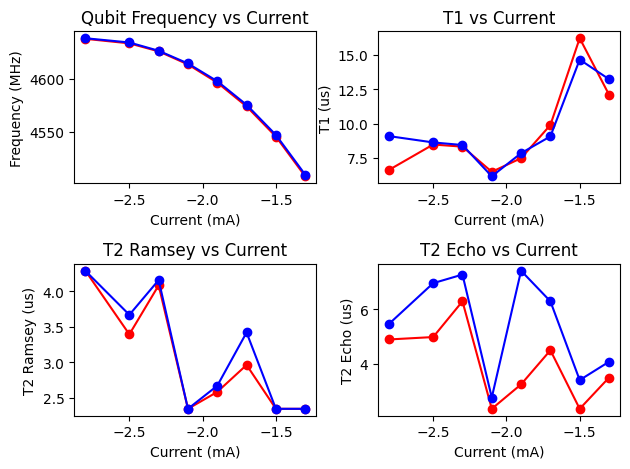

In [ ]:
currnet = np.array(jpaon)[:, 0]
onfreq = np.array(jpaon)[:, 1]
offfreq = np.array(jpaoff)[:, 1]

ont1 = np.array(jpaon)[:, 2]
offt1 = np.array(jpaoff)[:, 2]

ont2r = np.array(jpaon)[:, 3]
offt2r = np.array(jpaoff)[:, 3]

ont2e = np.array(jpaon)[:, 4]
offt2e = np.array(jpaoff)[:, 4]
fig, ax = plt.subplots(2, 2)
ax[0, 0].plot(currnet, onfreq, "o-", color="r")
ax[0, 0].plot(currnet, offfreq, "o-", color="b")
ax[0, 0].set_title("Qubit Frequency vs Current")
ax[0, 0].set_xlabel("Current (mA)")
ax[0, 0].set_ylabel("Frequency (MHz)")
ax[0, 1].plot(currnet, ont1, "o-", color="r")
ax[0, 1].plot(currnet, offt1, "o-", color="b")
ax[0, 1].set_title("T1 vs Current")
ax[0, 1].set_xlabel("Current (mA)")
ax[0, 1].set_ylabel("T1 (us)")

ax[1, 0].plot(currnet, ont2r, "o-", color="r")
ax[1, 0].plot(currnet, offt2r, "o-", color="b")
ax[1, 0].set_title("T2 Ramsey vs Current")
ax[1, 0].set_xlabel("Current (mA)")
ax[1, 0].set_ylabel("T2 Ramsey (us)")

ax[1, 1].plot(currnet, ont2e, "o-", color="r")
ax[1, 1].plot(currnet, offt2e, "o-", color="b")
ax[1, 1].set_title("T2 Echo vs Current")
ax[1, 1].set_xlabel("Current (mA)")
ax[1, 1].set_ylabel("T2 Echo (us)")
plt.tight_layout()